<a href="https://colab.research.google.com/github/akimi-yano/Face_With-Without_Mask_Detection/blob/main/TrainAFaceMaskDetectorWithYOLOV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train A Face Mask Detector with Yolo v4

# Clone the DarkNet Repository

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15873, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15873 (delta 3), reused 0 (delta 0), pack-reused 15863 (from 3)
Receiving objects: 100% (15873/15873), 14.47 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (10686/10686), done.


# Compile DarkNet

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!pwd

/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


# Set Up Structure

```bash
/darknet/
  ├── cfg/
  │   ├── yolov4-mask.cfg      # Created this config file for training (24/8)
  │   ├── yolov4-mask-test.cfg # Created this config file for testing (1/1)
  │   ├── mask.names           # Created a file for the class names
  │   ├── mask.data            # Created a file for dataset configuration
  ├── data/
  │   ├── datasets             # Added images files and label files
  │   ├── train.txt            # Created a file for paths to training images
  │   ├── val.txt              # Created a file for paths to validation images
  ├── backup/                  # Created a folder for saving weights

```

# Define yolov3.cfg

1.   Copied the yolov3.cfg file from the cfg folder of Darknet and crated a new file.
2.   Modified the configuration:

*   Updated the number of filters in the convolutional layer before each [yolo] layer to: ```filters = (classes + 5) * 3 = (2 + 5) * 3 = 21```
*   Updated the number of classes in each [yolo] layer: ```classes = 2```

# Define Classes by Creating obj.names

In [ ]:
class_names = ["Mask", "No-Mask"]

output_file_path = "/content/darknet/cfg/mask.names"

# Write the class names to the file
with open(output_file_path, "w") as file:
    for class_name in class_names:
        file.write(class_name + "\n")

print(f"'obj.names' file created successfully at {output_file_path}")


'obj.names' file created successfully at /content/darknet/cfg/mask.names


# Define Data Config by Creating obj.data

In [ ]:
obj_data_content = """classes = 2
train = /content/darknet/data/data_train.txt
valid = /content/darknet/data/data_test.txt
names = /content/darknet/cfg/mask.names
backup = /content/darknet/backup/
"""

# Path to save the obj.data file
output_file_path = "/content/darknet/cfg/mask.data"

# Write the content to the file
with open(output_file_path, "w") as file:
    file.write(obj_data_content)

print(f"'obj.data' file created successfully at {output_file_path}")


'obj.data' file created successfully at /content/darknet/cfg/mask.data


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
for dir in os.walk("/content/drive/My Drive/Mask_VS_No_Mask"):
  print(dir)

('/content/drive/My Drive/Mask_VS_No_Mask', ['Dataset', 'Test'], ['obj.names', 'obj.data', 'data_train.txt', 'data_test.txt', 'darknet53.conv.74', 'chart.png', 'chart_yolov3-mask.png', 'bad.list', 'predictions.jpg'])
('/content/drive/My Drive/Mask_VS_No_Mask/Dataset', [], ['961.txt', '906.jpg', '1008.txt', '1072.txt', '982.jpg', '926.txt', '1026.jpg', '747.jpg', '818.jpg', '739.txt', '987.jpg', '1035.jpg', '899.txt', '1051.txt', '848.txt', '878.txt', '745.jpg', '1076.txt', '934.txt', '773.txt', '825.jpg', '859.jpg', '995.txt', '925.txt', '680.txt', '959.txt', '942.txt', '873.txt', '989.txt', '979.txt', '737.jpeg', '677.jpg', '743.txt', '931.jpg', '915.jpg', '827.txt', '869.jpeg', '767.txt', '955.jpg', '723.jpg', '946.txt', '696.png', '1033.jpg', '724.jpg', '1040.txt', '989.jpg', '706.txt', '959.jpg', '851.jpg', '1058.txt', '860.txt', '870.txt', '667.txt', '929.jpeg', '897.txt', '865.txt', '761.txt', '988.jpg', '1032.jpeg', '680.jpg', '1057.jpg', '677.txt', '1006.txt', '951.jpg', '754.t

# Prepare Dataset Files

In [ ]:
import shutil

# Source directory
source_path = "/content/drive/My Drive/Mask_VS_No_Mask/Dataset"

# Destination directory with "dataset" subdirectory
destination_path = "/content/darknet/data/dataset"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy everything from source to destination
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print(f"All files and directories from '{source_path}' have been copied to '{destination_path}'")


All files and directories from '/content/drive/My Drive/Mask_VS_No_Mask/Dataset' have been copied to '/content/darknet/data/dataset'


In [ ]:
from sklearn.model_selection import train_test_split

image_dir = "/content/darknet/data/dataset"

all_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

with open("/content/darknet/data/data_train.txt", "w") as train_file:
    train_file.write("\n".join(train_images))
with open("/content/darknet/data/data_test.txt", "w") as val_file:
    val_file.write("\n".join(val_images))

In [ ]:
f_train = open("/content/darknet/data/data_train.txt", 'r')
print(f_train.read())
f_train.close()

/content/darknet/data/dataset/1156.jpg
/content/darknet/data/dataset/326.jpg
/content/darknet/data/dataset/586.jpg
/content/darknet/data/dataset/720.jpg
/content/darknet/data/dataset/1033.jpg
/content/darknet/data/dataset/1049.jpg
/content/darknet/data/dataset/262.jpg
/content/darknet/data/dataset/872.jpg
/content/darknet/data/dataset/204.jpg
/content/darknet/data/dataset/619.jpg
/content/darknet/data/dataset/1256.jpg
/content/darknet/data/dataset/311.jpg
/content/darknet/data/dataset/888.jpg
/content/darknet/data/dataset/95.jpg
/content/darknet/data/dataset/1178.jpg
/content/darknet/data/dataset/935.jpg
/content/darknet/data/dataset/540.jpg
/content/darknet/data/dataset/1119.jpg
/content/darknet/data/dataset/105.jpg
/content/darknet/data/dataset/543.jpg
/content/darknet/data/dataset/251.jpg
/content/darknet/data/dataset/322.jpg
/content/darknet/data/dataset/250.jpg
/content/darknet/data/dataset/155.jpg
/content/darknet/data/dataset/87.jpg
/content/darknet/data/dataset/1200.jpg
/conten

In [ ]:
f_val = open("/content/darknet/data/data_test.txt", 'r')
print(f_val.read())
f_val.close

/content/darknet/data/dataset/596.jpg
/content/darknet/data/dataset/464.jpg
/content/darknet/data/dataset/902.jpg
/content/darknet/data/dataset/1334.jpg
/content/darknet/data/dataset/646.jpg
/content/darknet/data/dataset/248.jpg
/content/darknet/data/dataset/652.jpg
/content/darknet/data/dataset/629.jpg
/content/darknet/data/dataset/671.jpg
/content/darknet/data/dataset/180.jpg
/content/darknet/data/dataset/1173.jpg
/content/darknet/data/dataset/394.jpg
/content/darknet/data/dataset/602.jpg
/content/darknet/data/dataset/1217.jpg
/content/darknet/data/dataset/1208.jpg
/content/darknet/data/dataset/830.jpg
/content/darknet/data/dataset/1245.jpg
/content/darknet/data/dataset/773.jpg
/content/darknet/data/dataset/811.jpg
/content/darknet/data/dataset/238.jpg
/content/darknet/data/dataset/1029.jpg
/content/darknet/data/dataset/1028.jpg
/content/darknet/data/dataset/368.jpg
/content/darknet/data/dataset/1071.jpg
/content/darknet/data/dataset/1151.jpg
/content/darknet/data/dataset/884.jpg
/co

<function TextIOWrapper.close()>

# Download Weights for Convolutional Backbone

In [ ]:
# Saved the yolov4.conv.137 at /content/darknet/build/darknet/x64/ (LINK: https://github.com/AlexeyAB/darknet?tab=readme-ov-file#how-to-train-to-detect-your-custom-objects)

# Checks

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!ls .

3rdparty       CMakeLists.txt	       docker-compose.yml     LICENSE	     results
backup	       darknet		       Dockerfile.cpu	      Makefile	     scripts
build	       DarknetConfig.cmake.in  Dockerfile.gpu	      net_cam_v3.sh  src
build_log.txt  darknet_images.py       image_yolov3.sh	      net_cam_v4.sh  vcpkg.json
build.ps1      darknet.py	       image_yolov4.sh	      obj	     video_yolov3.sh
cfg	       darknet_video.py        include		      package.xml    video_yolov4.sh
cmake	       data		       json_mjpeg_streams.sh  README.md


# Start Training

In [ ]:
!/content/darknet/darknet detector train /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask.cfg /content/darknet/build/darknet/x64/yolov4.conv.137 -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.803075), count: 25, class_loss = 1.906426, iou_loss = 28.584045, total_loss = 30.490471 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.565571), count: 5, class_loss = 0.344664, iou_loss = 0.326811, total_loss = 0.671476 
 total_bbox = 457198, rewritten_bbox = 0.103456 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.579070), count: 48, class_loss = 10.769363, iou_loss = 391.777557, total_loss = 402.546936 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.730696), count: 8, class_loss = 4.097383, iou_loss = 5.009814, total_loss = 9.107197 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.526776), count: 5, class_loss = 0.663066, iou_loss = 0.300540, total_loss = 0.963606 
 total_bbox = 457259, rewritten_bbox = 0.103

# Performance Inference

In [ ]:
test_video_dir = "/content/drive/My Drive/Mask_VS_No_Mask/Test/Videos/"
test_image_dir = "/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/"

In [ ]:
print(os.listdir(test_video_dir))
print(os.listdir(test_image_dir))

['test-video1.mp4', 'test-video2.mp4']
['test-image1.jpg', 'test-image2.jpg', 'test-image3.jpg', 'test-image4.jpg']


In [ ]:
test_images = [f"{test_image_dir}test-image{i+1}.jpg" for i in range(4)]

In [ ]:
test_images

['/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image1.jpg',
 '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image2.jpg',
 '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image3.jpg',
 '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image4.jpg']

In [ ]:
test_videos = [f"{test_video_dir}test-video{i+1}.mp4" for i in range(2)]

In [ ]:
test_videos

['/content/drive/My Drive/Mask_VS_No_Mask/Test/Videos/test-video1.mp4',
 '/content/drive/My Drive/Mask_VS_No_Mask/Test/Videos/test-video2.mp4']

In [ ]:
# !ls ./data/labels

In [ ]:
# !ls -l ./data/labels

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("/content/darknet/predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

In [ ]:
for img in test_images:
    if not os.path.exists(img):
        print(f"Image not found: {img}")
    else:
        print("Image path exists")

Image path exists
Image path exists
Image path exists
Image path exists


# Test Image 1

In [ ]:
!./darknet detector test /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image1.jpg' -thresh .6 2> /dev/null

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 21 K-images (0 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 
/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image1.jpg: Predicted in 177.605000 milli-seconds.
Mask: 70%


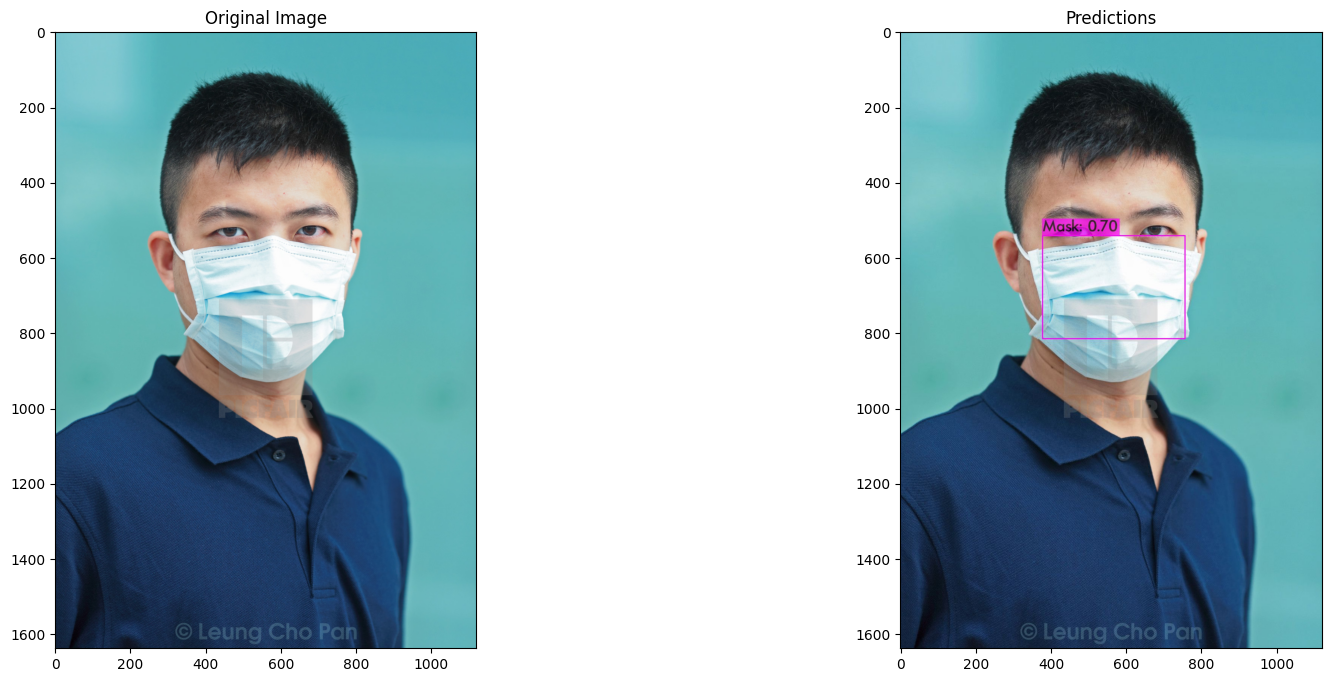

In [ ]:
display_output('/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image1.jpg')

# Test Image 2

In [ ]:
!./darknet detector test /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image2.jpg' -thresh .6 2> /dev/null

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 21 K-images (0 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 
/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image2.jpg: Predicted in 99.728000 milli-seconds.
Mask: 97%
Mask: 94%
No-Mask: 92%
Mask: 65%


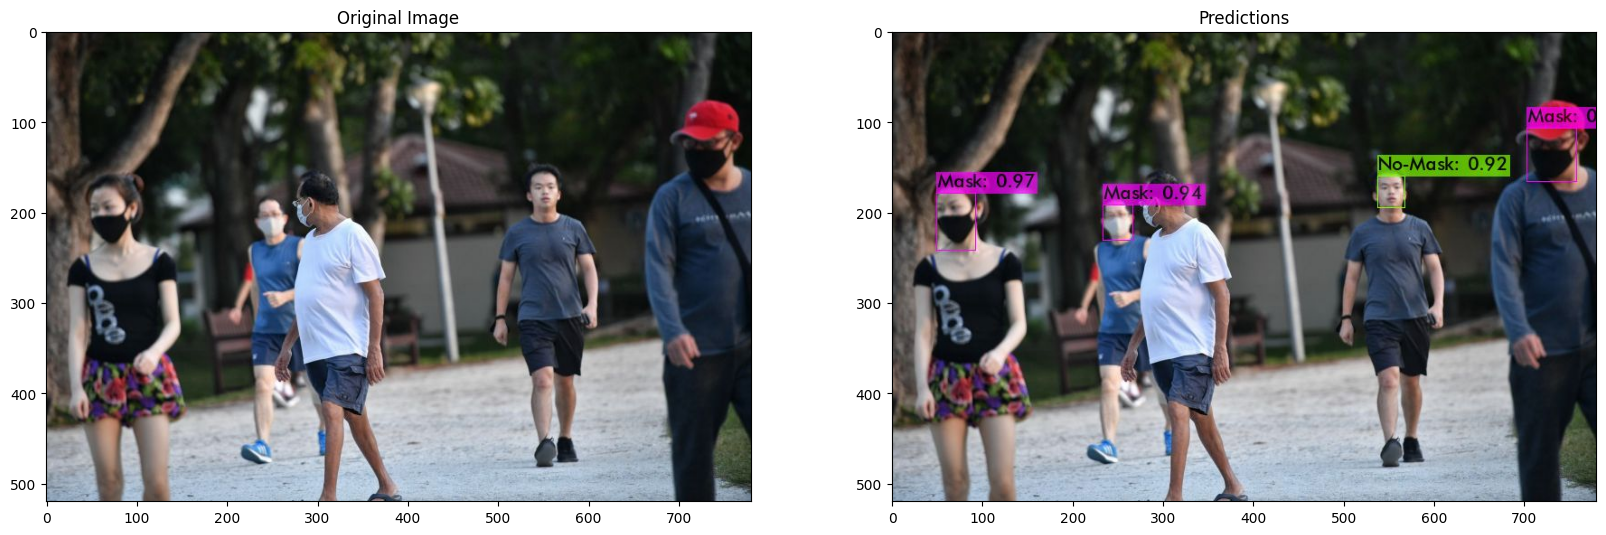

In [ ]:
display_output('/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image2.jpg')

# Test Image 3

In [ ]:
!./darknet detector test /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image3.jpg' -thresh .6 2> /dev/null

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 21 K-images (0 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 
/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image3.jpg: Predicted in 140.090000 milli-seconds.
Mask: 96%
Mask: 76%
Mask: 90%
Mask: 98%
Mask: 93%
Mask: 92%
Mask: 79%
Mask: 95%
Mask: 91%
Mask: 86%
Mask: 87%
Mask: 99%
Mask: 92%
Mask: 97%
Mask: 98%
Mask: 93%
Mask: 89%
Mask: 98%


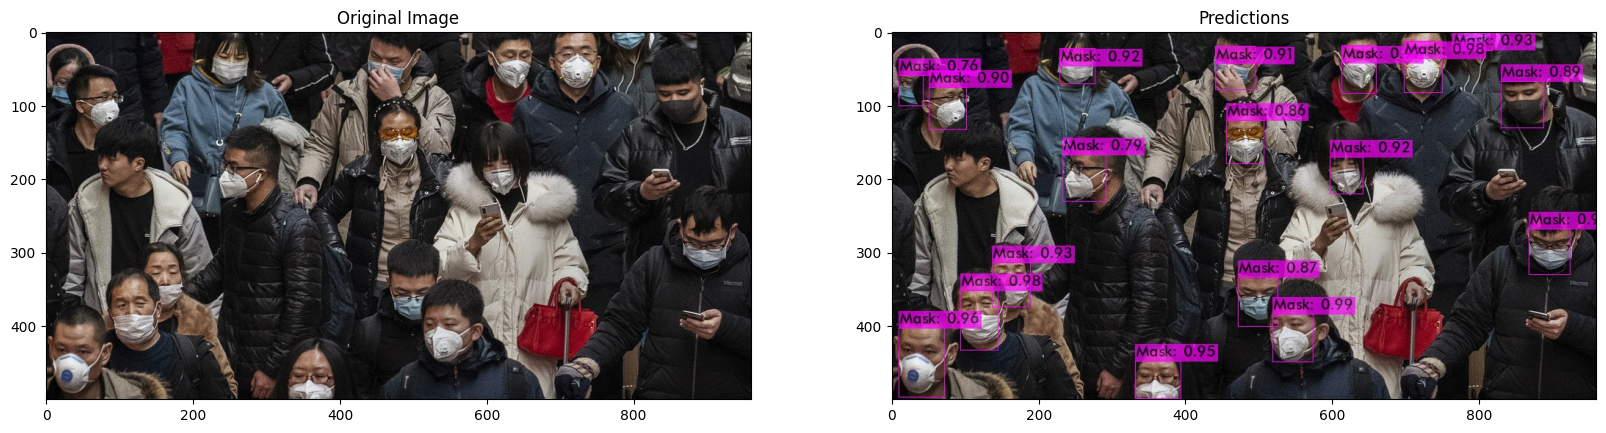

In [ ]:
display_output('/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image3.jpg')

# Test Image 4

In [ ]:
!./darknet detector test /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image4.jpg' -thresh .6 2> /dev/null

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 21 K-images (0 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 
/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image4.jpg: Predicted in 107.257000 milli-seconds.
No-Mask: 80%
No-Mask: 89%
Mask: 80%
No-Mask: 63%
Mask: 96%
No-Mask: 62%
Mask: 92%
Mask: 97%


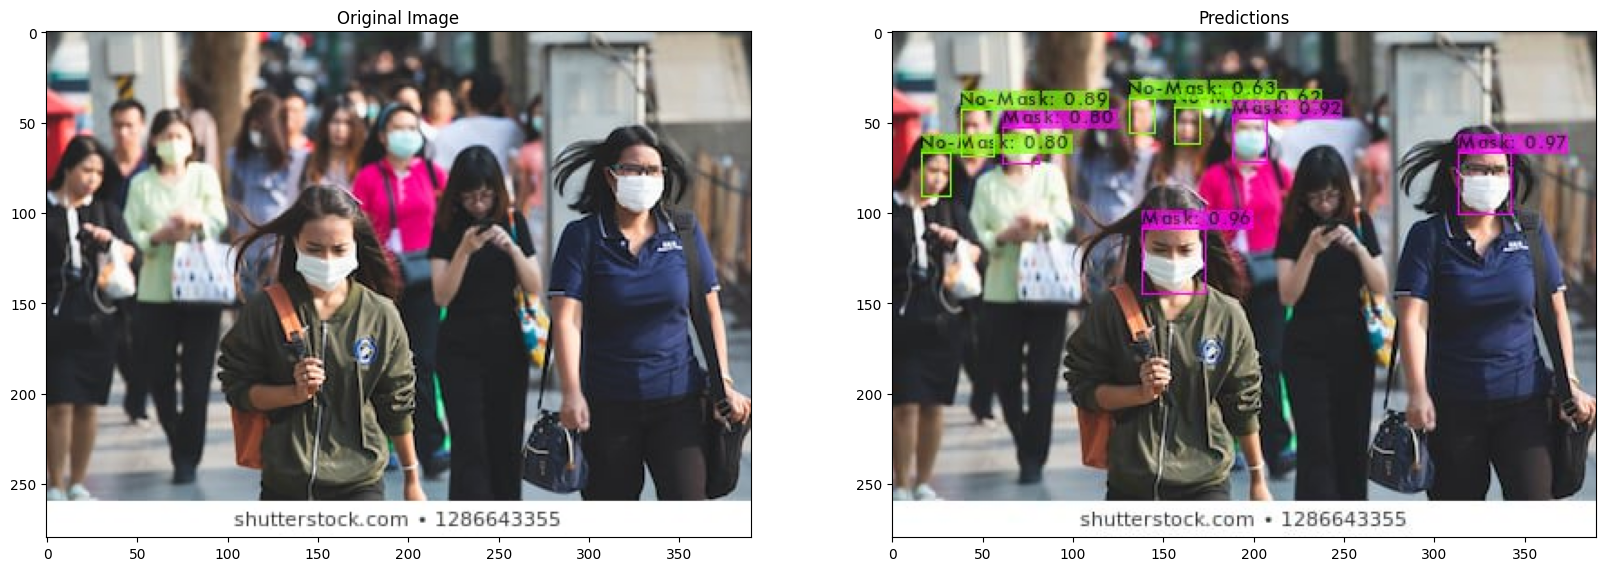

In [ ]:
display_output('/content/drive/My Drive/Mask_VS_No_Mask/Test/Images/test-image4.jpg')

# Test Video 1

In [ ]:
!./darknet detector demo /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Videos/test-video1.mp4' -thresh .6 -out_filename out-vid1.mp4 -dont_show

Streaming output truncated to the last 5000 lines.
FPS:31.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 87% 
No-Mask: 86% 
No-Mask: 63% 
Mask: 92% 

FPS:31.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 87% 
No-Mask: 86% 
No-Mask: 64% 
Mask: 92% 

FPS:32.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 88% 
No-Mask: 87% 
No-Mask: 86% 
Mask: 92% 
Mask: 66% 

FPS:31.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 88% 
No-Mask: 86% 
No-Mask: 86% 
Mask: 86% 
Mask: 65% 

FPS:32.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 88% 
No-Mask: 87% 
No-Mask: 85% 
Mask: 87% 
Mask: 83% 

FPS:32.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 88% 
No-Mask: 86% 
No-Mask: 86% 
Mask: 91% 
Mask: 83% 

FPS:32.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 86% 
No-Mask: 85% 
Mask: 91% 
Mask: 76% 

FPS:31.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 87% 
No-Mask: 84% 
Mask: 91% 
Mask: 76% 

FPS:31.2 	 AVG_FPS:0.0

 cvWrit

# Test Video 2

In [ ]:
!./darknet detector demo /content/darknet/cfg/mask.data /content/darknet/cfg/yolov4-mask-test.cfg /content/darknet/backup/yolov4-mask_last.weights '/content/drive/My Drive/Mask_VS_No_Mask/Test/Videos/test-video2.mp4' -thresh .6 -out_filename out-vid2.mp4 -dont_show

Streaming output truncated to the last 5000 lines.

FPS:34.8 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 77% 
No-Mask: 67% 
Mask: 95% 
Mask: 81% 

FPS:34.7 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

Mask: 96% 
Mask: 61% 

FPS:34.4 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 85% 
No-Mask: 69% 
No-Mask: 66% 
Mask: 79% 

FPS:34.9 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 60% 
Mask: 85% 

FPS:34.6 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

Mask: 87% 

FPS:34.2 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 62% 
Mask: 65% 

FPS:34.3 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 62% 
Mask: 88% 

FPS:33.8 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 84% 
Mask: 94% 

FPS:33.9 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 64% 
Mask: 80% 

FPS:34.0 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 81% 
No-Mask: 66% 

FPS:34.2 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 82% 
No-Mask: 67% 

FPS:34.0 	 AVG_FPS:33.6

 cvWriteFrame 
Objects:

No-Mask: 75% 
Mask: 